# Ising Chain with long range interactions

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Fitting procedure

We define the model

$$
    f(A, B, C, D, E, F) = A x^2 + B x y + C y^2 + D x + E y + F
$$

In [3]:
def conic_section_eq(coefs, x, y):
    """Evaluates the conic section equation for the given coefficients."""
    a, b, c, d, e, f = coefs
    return (
        a* x ** 2 +
        b * x * y +
        c * y ** 2 +
        d * x +
        e * y +
        f
    )

def residuals_func(coefs):
    """Calculate the residuals for the least squares minimization routine.
    
    This function returns an array with the difference between the expected value
    of the model, which we set to zero for all x and y, and the predictions of the
    model.
    """
    a, b, c, d, e, f = coefs
    # We want the model to be almost zero, i.e., that the coefficients and data
    # satisfy the conic equation.
    residuals = 0 - (
        a * x_data ** 2 +
        b * x_data * y_data +
        c * y_data ** 2 +
        d * x_data +
        e * y_data +
        f
    )
    return residuals

def residuals_func_sum_sqr(coefs):
    """Calculate the sum of the squared residuals."""
    return np.sum(residuals_func(coefs) ** 2)

## Data handling

### Import properties data from disk

In [4]:
data_path = Path("../../data/").resolve()
file = 'all_inv_Tc.csv'
inv_temp_data = pd.read_csv(os.path.join(data_path,file))
inv_temp_data

,1/nv,P1.0,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
0,0.500000,0.662721,0.680297,0.700150,0.717028,0.734866,0.751727,0.770168,0.786703,0.803441,0.820681,0.835529
1,0.333333,0.505386,0.528284,0.546419,0.574539,0.597153,0.619581,0.642793,0.665299,0.687169,0.709461,0.732735
2,0.250000,0.425707,0.450768,0.472832,0.501265,0.528284,0.555318,0.580268,0.606328,0.631346,0.656782,0.680642
3,0.200000,0.375812,0.402337,0.429970,0.456688,0.485307,0.512765,0.541671,0.569954,0.598822,0.626314,0.653388
4,0.166667,0.341083,0.368523,0.396765,0.424721,0.455167,0.486573,0.515543,0.545704,0.574864,0.605612,0.634517
5,0.142857,0.315105,0.343136,0.372431,0.401683,0.432891,0.463020,0.495621,0.527741,0.560164,0.590963,0.622788
6,0.125000,0.294999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.111111,0.278617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.100000,0.265052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.090909,0.253624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# inv_temp_data[0] = 0
x_data_all = inv_temp_data.loc[:, "1/nv"]
y_data_all = inv_temp_data.loc[:, "P1.0"]

x_data = np.array(inv_temp_data.loc[y_data_all.notnull(), "1/nv"])
y_data = np.array(y_data_all.loc[y_data_all.notnull()])

In [15]:
x_data, y_data

(array([0.5       , 0.33333333, 0.25      , 0.2       , 0.16666667,
        0.14285714, 0.06666667, 0.05      ]),
 array([0.68029698, 0.52828397, 0.45076787, 0.40233737, 0.36852339,
        0.34313569, 0.25038224, 0.22548399]))

## Fitting using `least_squares` routine

In [42]:
best_fit_result = least_squares(residuals_func, x0=(1, 1, 1, 1, 1))
# print(best_fit_result)
best_fit_coefs = best_fit_result.x
# best_fit_coefs / best_fit_coefs.min()
print("Best fit parameters:", best_fit_coefs)

Best fit parameters: [-1.65115651  0.61824472  0.29584867 -0.20891643  0.016123  ]


## Fitting using ``minimize`` routine

Function ``minimize`` finds local minima only, so we have to pass an initial estimate for the solution.

In [11]:
best_fit_result = minimize(residuals_func_sum_sqr, x0=(1, 0, 1, 0, 0, 1))
print(best_fit_result)
best_fit_coefs = best_fit_result.x
print("Best fit parameters:", best_fit_coefs)

      fun: 1.9705524733594574e-08
 hess_inv: array([[  364.98133944,   -56.58065505,   257.73093847, -1383.28823679,
          981.22722348,  -139.62578496],
       [  -56.58065505,    29.54299648,   -44.77532141,   281.78136183,
         -226.97532941,    34.38663754],
       [  257.73093847,   -44.77532141,   184.5803422 ,  -995.43700619,
          712.40283951,  -101.94260451],
       [-1383.28823679,   281.78136183,  -995.43700619,  5483.71472937,
        -3980.81135224,   573.47392913],
       [  981.22722348,  -226.97532941,   712.40283951, -3980.81135224,
         2926.25594493,  -424.47137718],
       [ -139.62578496,    34.38663754,  -101.94260451,   573.47392913,
         -424.47137718,    61.86060644]])
      jac: array([-1.43208303e-07, -8.23579862e-08, -1.38832035e-08, -2.17009428e-07,
       -5.66011785e-07, -2.15002651e-06])
  message: 'Optimization terminated successfully.'
     nfev: 256
      nit: 31
     njev: 32
   status: 0
  success: True
        x: array([ 0.2605

## Find a global minimum in a specific region

We can use the ``differential_evolution`` function to find a global minimum in a region. In this case we have to
indicate the region boundaries in the form ``[(amin, amax), (bmin, bmax), ...]``

In [50]:
best_fit_result = differential_evolution(residuals_func_sum_sqr, bounds=[
     (-10, 10), (-10, 10), (-10, 10), (-10, 10), (-10, 10)
])
best_fit_coefs = best_fit_result.x
print("Best fit parameters:", best_fit_coefs)

Best fit parameters: [-1.65108398  0.61823189  0.29569164 -0.20880155  0.01610765]


In [223]:
best_fit_coefs / abs(best_fit_coefs.max())

array([ 1.        , -1.405142  ,  0.34893871,  0.27025411, -0.12236173,
        0.00825112])

In [224]:
best_fit_result

     fun: 1.2946862585373424e-28
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 90097
     nit: 1000
 success: False
       x: array([ 3.71369602e-11, -5.21827026e-11,  1.29585231e-11,  1.00364161e-11,
       -4.54414284e-12,  3.06421555e-13])

## Plots

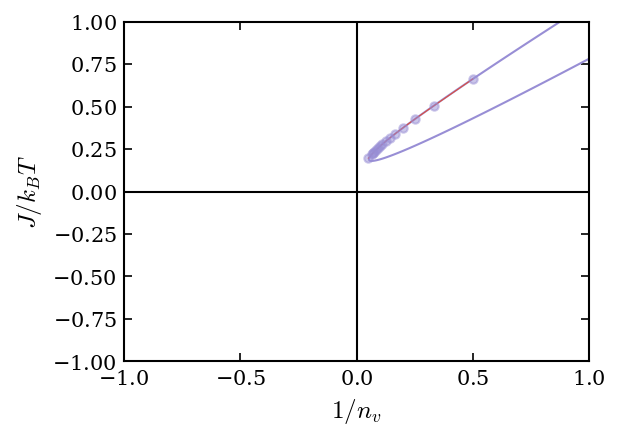

In [12]:
use_tex = False

# Load the default style.
style.use("default")
rcParams["text.usetex"] = use_tex

fig1: Figure = pyplot.figure(figsize=(4, 3), dpi=150)
grid_spec = GridSpec(1, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])
    
ax.plot((x_data), y_data, lw=0.5)
ax.plot((x_data), y_data, marker="o", lw=0, alpha=0.5,color='C9')

# Since we cannot find y as a function of x, we make a contour plot of the model
# function, and draw the level where the model is zero.
x_data_fine = np.linspace(-1, 1, num=1024)
y_data_fine = np.linspace(-1, 1, num=1024)
x_data_mat, y_data_mat = np.meshgrid(x_data_fine, y_data_fine, sparse=True)
z_data_mat = conic_section_eq(best_fit_coefs, x_data_mat, y_data_mat)
# z_data_mat = conic_section_eq(best_fit_coefs / abs(best_fit_coefs.max()), x_data_mat, y_data_mat)

ax.contour(x_data_fine, y_data_fine, z_data_mat, levels=[0],colors=['C'+str(9)])

ax.set_xlabel(r"$1 / n_v$")
ax.set_ylabel(r"$J / k_B T$")

ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
# ax.set_xscale("log")
# ax.set_yscale("log")

pyplot.draw()
pyplot.show()

### Fit all p

Best fit parameters: [ 0.23052047 -0.03454457 -0.24334787  0.0530861   0.05956064 -0.00533605]
Best fit parameters: [ 0.22538155 -0.04725719 -0.24265232  0.05932392  0.072677   -0.00709113]
Best fit parameters: [ 0.23728906 -0.06535829 -0.20906397 -0.01325526  0.13110698 -0.0191385 ]
Best fit parameters: [ 0.21403073 -0.07088631 -0.25204049  0.100596    0.08016402 -0.00637596]
Best fit parameters: [ 0.19998902 -0.08210703 -0.2474147   0.11669845  0.08222405 -0.00515876]
Best fit parameters: [ 0.18184558 -0.08911742 -0.243044    0.13794764  0.07533319 -0.00045238]
Best fit parameters: [ 0.18997957 -0.12297786 -0.16698219  0.03756994  0.14417816 -0.03092268]
Best fit parameters: [ 0.16823754 -0.13148338 -0.1367428   0.03707363  0.14074068 -0.03496973]
Best fit parameters: [ 0.13534601 -0.13056143 -0.0918918   0.02804743  0.12887519 -0.03963486]
Best fit parameters: [ 0.20088982 -0.0256633  -0.370388    0.28301037 -0.08004035  0.13360306]
Best fit parameters: [ 0.24663701  0.00629821 -0.4

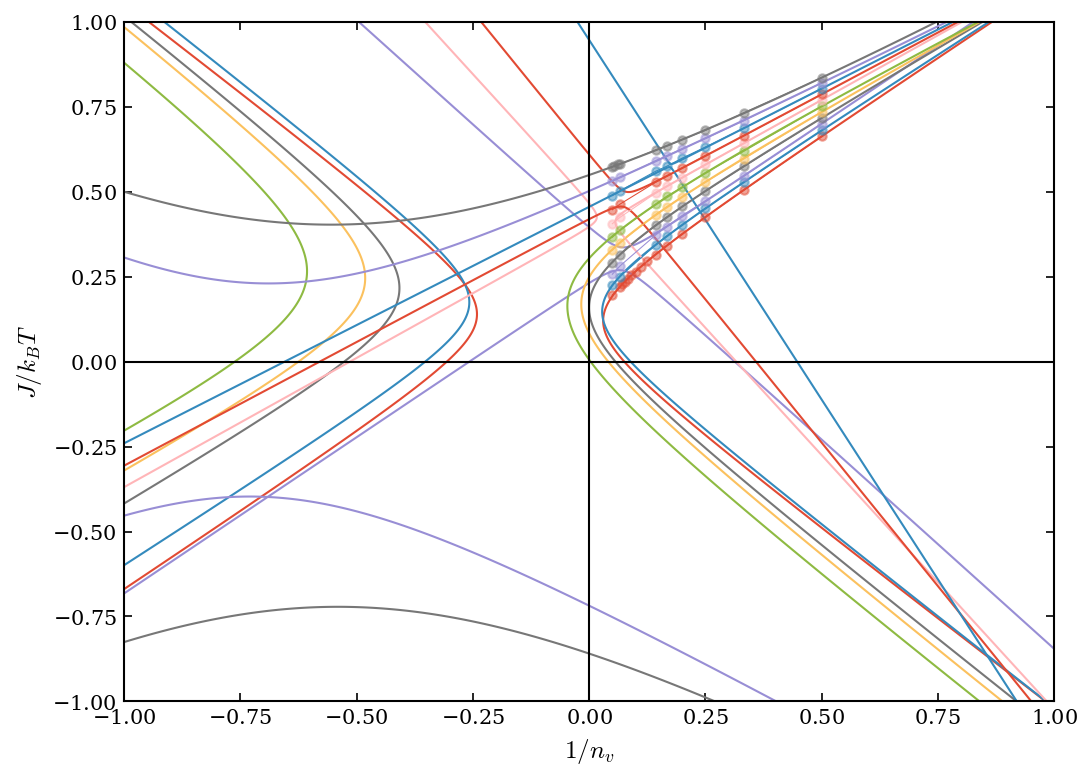

In [39]:
columns = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
params = []

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(8, 6), dpi=150)
grid_spec = GridSpec(1, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

# function, and draw the level where the model is zero.
x_data_fine = np.linspace(-1, 1, num=1024)
y_data_fine = np.linspace(-1, 1, num=1024)
x_data_mat, y_data_mat = np.meshgrid(x_data_fine, y_data_fine, sparse=True)

    
for index,column in enumerate(columns):
    x_data_all = inv_temp_data.loc[:, "1/nv"]
    y_data_all = inv_temp_data.loc[:, column]

    x_data = np.array(inv_temp_data.loc[y_data_all.notnull(), "1/nv"])
    y_data = np.array(y_data_all.loc[y_data_all.notnull()])
    
    best_fit_result = minimize(residuals_func_sum_sqr, x0=(2, 2, 2, 2, 2, 2))
    best_fit_coefs = best_fit_result.x
    print("Best fit parameters:", best_fit_coefs)
    params.append(best_fit_coefs);
    
    # Plot

    ax.plot((x_data), y_data, lw=0.5)
    ax.plot((x_data), y_data, marker="o", lw=0, alpha=0.5,color='C'+str(index))

    # Since we cannot find y as a function of x, we make a contour plot of the model
    z_data_mat = conic_section_eq(best_fit_coefs, x_data_mat, y_data_mat)
    # z_data_mat = conic_section_eq(best_fit_coefs / abs(best_fit_coefs.max()), x_data_mat, y_data_mat)

    ax.contour(x_data_fine, y_data_fine, z_data_mat, levels=[0],colors=['C'+str(index)])
    

ax.set_xlabel(r"$1 / n_v$")
ax.set_ylabel(r"$J / k_B T$")

ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
# ax.set_xscale("log")
# ax.set_yscale("log")

pyplot.draw()
pyplot.show()

In [77]:
(1,) * 10

(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

In [81]:
[(-1, 1)] * 6

[(-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)]